In [2]:
# load the change in the files
%load_ext autoreload
%autoreload 2

In [3]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

/home/miyen/miniconda3/envs/dif/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the forward diffusion process


In [10]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [11]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [13]:
import os
import sys
# append the parent directory to path
sys.path.append('/home/miyen/diffusion-features/diffusion-features')
# sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from utils.get_trajectories import get_trajectories
trajectories = get_trajectories()
trajectories = torch.tensor(trajectories, dtype=torch.float32)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

/home/miyen/diffusion-features/environment/data/lavaenv
tensor([[[1., 4.],
         [1., 3.],
         [1., 2.],
         [2., 2.],
         [3., 2.],
         [4., 2.],
         [5., 2.],
         [6., 2.],
         [7., 2.],
         [8., 2.],
         [8., 3.],
         [8., 4.],
         [8., 5.],
         [8., 6.],
         [8., 7.],
         [8., 8.]]])


/home/miyen/diffusion-features/diffusion-features/utils/get_trajectories.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  trajectories_tensor = torch.tensor([trajectory for trajectory in trajectories.values()])
/tmp/ipykernel_844592/2999026072.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [16]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [17]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [18]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

tensor([[[1., 4.],
         [1., 3.],
         [1., 2.],
         [2., 2.],
         [3., 2.],
         [4., 2.],
         [5., 2.],
         [6., 2.],
         [7., 2.],
         [8., 2.],
         [8., 3.],
         [8., 4.],
         [8., 5.],
         [8., 6.],
         [8., 7.],
         [8., 8.]]])
tensor([[[0.9907, 4.0071],
         [0.9836, 2.9849],
         [0.9965, 2.0074],
         [1.9986, 2.0054],
         [3.0100, 2.0039],
         [3.9988, 2.0084],
         [5.0099, 2.0055],
         [6.0181, 2.0040],
         [7.0120, 2.0035],
         [8.0009, 2.0153],
         [8.0083, 2.9948],
         [8.0021, 4.0017],
         [8.0060, 4.9966],
         [7.9752, 6.0060],
         [7.9998, 6.9879],
         [7.9985, 8.0050]]])


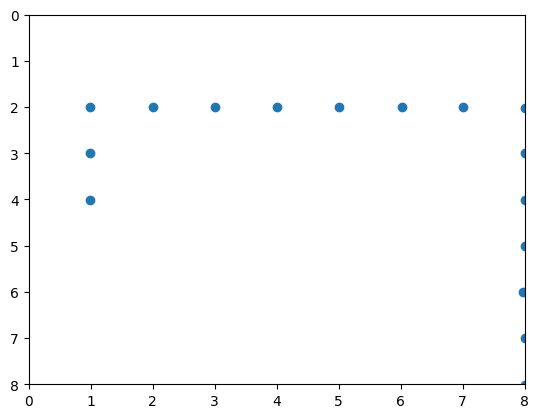

tensor([[[1.1418, 4.1179],
         [0.7083, 3.1500],
         [0.8988, 1.6034],
         [1.7584, 2.2038],
         [3.0415, 1.9667],
         [3.5752, 2.0043],
         [4.7936, 1.9220],
         [6.0264, 1.9632],
         [7.0680, 1.8139],
         [7.6786, 2.0422],
         [7.9195, 3.0230],
         [7.7680, 3.5852],
         [7.9709, 4.7391],
         [7.8600, 5.6516],
         [7.8761, 6.8581],
         [7.4180, 7.9043]]])


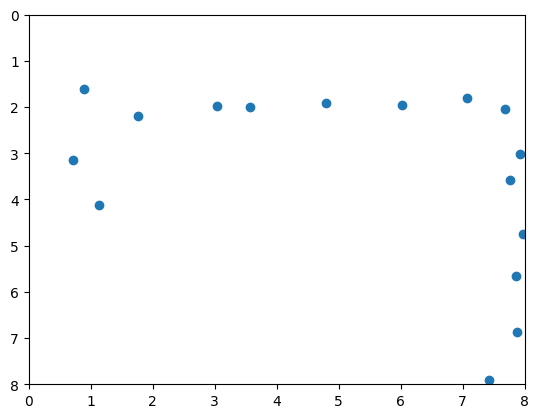

tensor([[[0.7972, 3.5390],
         [0.2981, 3.6090],
         [1.0141, 1.6499],
         [1.3963, 1.2383],
         [2.7605, 2.3077],
         [4.3122, 1.4034],
         [4.3284, 1.7456],
         [4.9294, 1.8747],
         [6.0746, 2.4061],
         [6.8970, 1.4765],
         [7.7516, 3.1430],
         [6.1929, 3.4297],
         [6.6058, 5.2458],
         [7.5048, 6.1930],
         [7.1282, 5.7008],
         [7.8701, 6.6305]]])


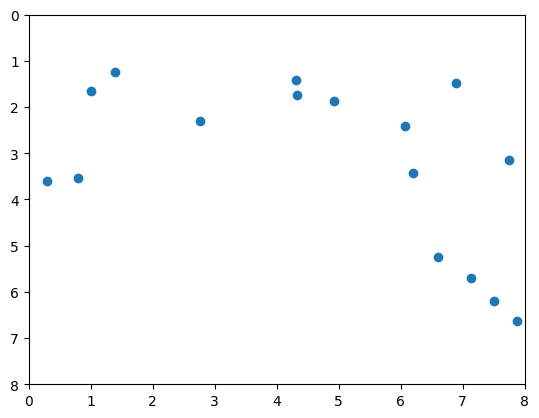

tensor([[[ 0.3052,  3.0447],
         [ 0.7661,  2.0623],
         [ 0.5667,  1.8356],
         [ 0.5053,  0.2022],
         [ 2.1561,  1.3718],
         [ 3.3657,  0.6163],
         [ 3.4771, -0.4480],
         [ 5.3656,  1.4573],
         [ 6.5971,  0.9624],
         [ 6.0641,  0.9816],
         [ 6.9071,  2.6765],
         [ 7.5612,  3.6425],
         [ 6.2097,  3.7831],
         [ 6.5352,  4.4065],
         [ 7.0125,  4.2435],
         [ 7.3218,  5.6707]]])


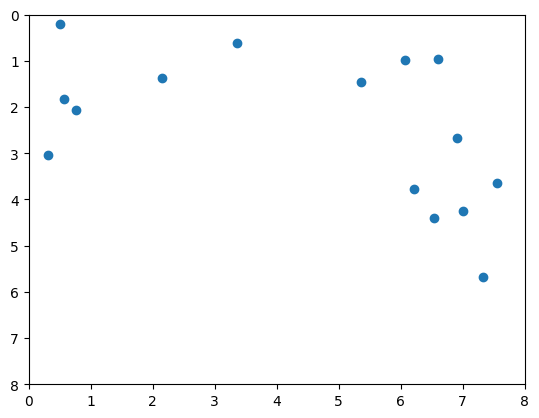

tensor([[[ 1.9177, -1.6549],
         [-0.8661,  1.0394],
         [-0.1871,  1.7657],
         [ 0.3445, -0.0097],
         [ 0.0942, -0.4313],
         [-0.0150,  1.9065],
         [ 0.4003,  0.0194],
         [ 1.9842,  0.5099],
         [ 1.9951, -0.0443],
         [ 2.8157, -0.6183],
         [ 1.3454,  0.8796],
         [ 0.9769,  0.4948],
         [-0.3634,  2.8803],
         [ 0.4549,  2.8157],
         [ 0.1148,  0.6113],
         [ 1.6387,  3.3723]]])


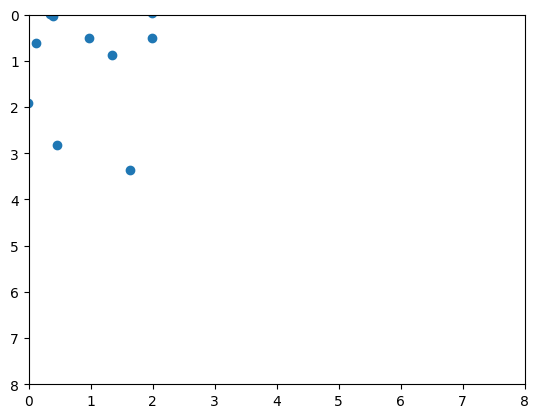

tensor([[[ 0.3647,  1.0222],
         [ 0.3216, -1.8333],
         [ 0.1774,  2.3965],
         [-0.7415,  0.4912],
         [ 0.6664,  1.2826],
         [ 0.7994, -0.0091],
         [ 0.0364, -0.4691],
         [ 0.6506, -0.1904],
         [-0.5995,  0.0297],
         [ 2.6602,  0.8947],
         [-0.1049, -1.4888],
         [ 0.7430,  0.3893],
         [-0.6984,  1.4385],
         [ 1.4715,  0.1769],
         [ 0.2653, -1.0178],
         [ 1.2045,  0.1843]]])


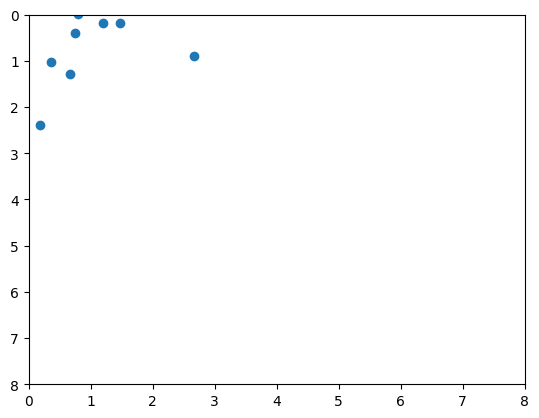

In [90]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start)
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [21]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [42]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [26]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [113]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(1000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            # print('x shape:', x.shape)
            # print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [114]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
trajectories = trajectories[:32]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=0,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

cuda
torch.Size([32, 16, 2])


Let's start training!

In [115]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 100
batch_size = 8
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      # start_states = batch[:, 0, :]
      # end_states = batch[:, -1, :]
      # condition = torch.cat((start_states, end_states), axis=1)
      condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.47760796546936035
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.49335241317749023
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4780392050743103
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.39480072259902954
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3855113983154297
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4532836973667145
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.43719175457954407
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4184289872646332
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.41638949513435364
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.34543704986572266
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.44391775131225586
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.43917107582092285
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.42494627833366394


/tmp/ipykernel_844592/566316448.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.37080878019332886
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.423176646232605
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3977128565311432
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.46605587005615234
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4105990529060364
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.42509403824806213
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3596484661102295
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4667676091194153
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4216492176055908
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3961251974105835
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3896597623825073
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3545653223991394
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.45252490043640137
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.436278

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [116]:
# global_cond = torch.tensor([0, 0, 1, 1]).unsqueeze(0).to(device)
global_cond = None
samples = sample_trajectories(model=model, traj_size=16, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_844592/566316448.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step:  10%|█         | 51/500 [00:00<00:02, 166.70it/s]

sampling loop time step: 100%|██████████| 500/500 [00:02<00:00, 167.59it/s]

500


(1, 16, 2)
[[[ 1.9480817 -3.3957524]
  [ 4.557147  -4.4337244]
  [ 9.980755   6.324724 ]
  [ 7.008171  -1.0040579]
  [ 1.9432135 10.577385 ]
  [ 3.9167135  7.25886  ]
  [ 7.4254065 -1.3336663]
  [ 1.6539574  8.496397 ]
  [-0.6857605 -2.7647743]
  [-1.2660995  3.626115 ]
  [ 9.404369  -0.5384331]
  [ 1.9277558  3.152775 ]
  [-3.4567528  6.3595576]
  [ 1.4317446  6.601815 ]
  [-1.3446655  4.198882 ]
  [ 9.304723   2.632408 ]]]


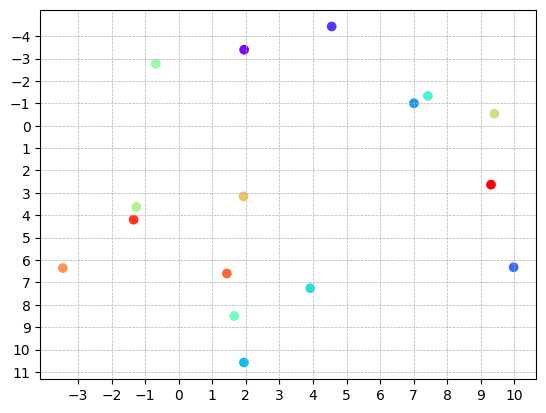

(1, 16, 2)
[[[ 6.0907288  -6.738858  ]
  [ 1.2153835  -5.456484  ]
  [13.365213   10.418161  ]
  [12.246184    0.6356592 ]
  [-4.535343   11.533114  ]
  [ 2.0323305   1.4176474 ]
  [ 4.6178617   2.7020962 ]
  [ 5.898572    7.3523507 ]
  [-0.3930893   0.6305189 ]
  [-3.2719498   0.5973985 ]
  [ 7.601164   -1.557147  ]
  [ 2.9942887  -0.27737427]
  [ 0.6790786   7.3280144 ]
  [ 4.589852    4.403536  ]
  [-0.12341404  5.0677733 ]
  [ 2.7582943   3.3256295 ]]]


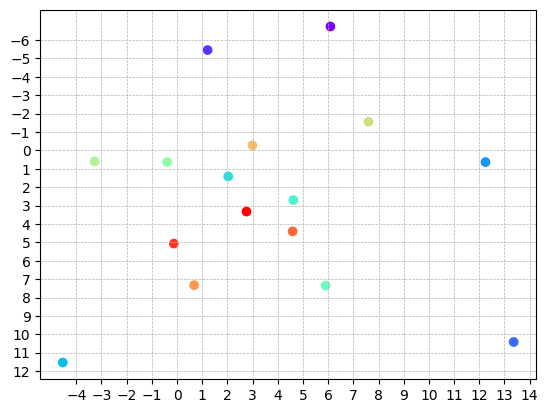

(1, 16, 2)
[[[ 6.3577576   2.6242888 ]
  [-1.0346627  -4.1088104 ]
  [12.908823   16.32449   ]
  [16.07412     5.106824  ]
  [ 1.6049795  10.912079  ]
  [ 2.143353    4.0428066 ]
  [ 5.669404    2.8959298 ]
  [ 3.1975756   8.066796  ]
  [ 0.5510731   4.600828  ]
  [-2.738707    0.8149624 ]
  [ 3.9608655   1.6828632 ]
  [ 2.9399765   3.4808388 ]
  [-2.4057722   7.153758  ]
  [ 7.0785847  -1.3661504 ]
  [-5.3358917   0.16929913]
  [-3.9913483  -1.4508276 ]]]


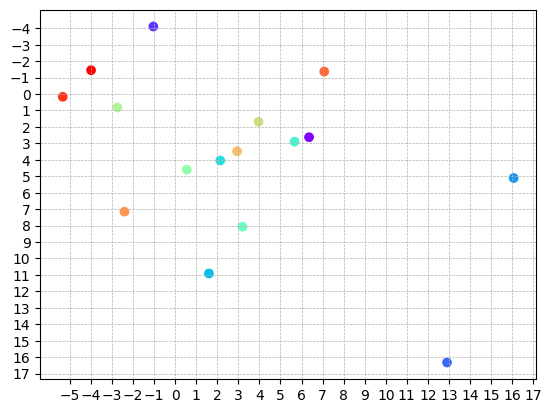

(1, 16, 2)
[[[ 7.1878414   6.8079157 ]
  [ 2.724336   -6.103875  ]
  [11.787989   16.034874  ]
  [11.220564    4.874257  ]
  [-0.941669    4.5527205 ]
  [ 6.930602   15.022309  ]
  [10.432776    6.528803  ]
  [14.264108    1.4808793 ]
  [ 2.2041912   8.45981   ]
  [-4.015731    1.4684918 ]
  [ 0.11196423  4.188683  ]
  [ 2.633224    3.2429664 ]
  [-4.992716   10.682389  ]
  [ 8.53861     3.121808  ]
  [-7.691366   -1.9806662 ]
  [-2.3894281  -1.1825552 ]]]


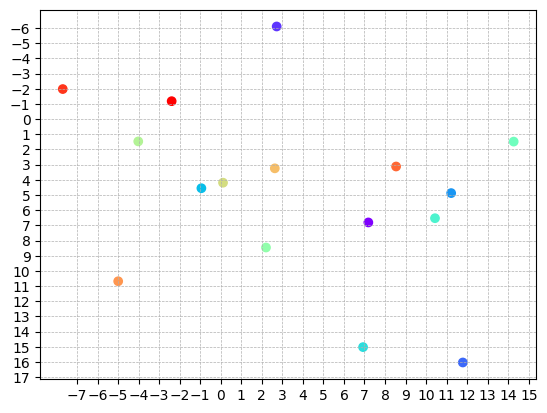

(1, 16, 2)
[[[ 8.251163    8.188868  ]
  [ 9.898276   -0.6584301 ]
  [ 4.248211   12.331927  ]
  [12.8763485   8.412563  ]
  [ 5.2581825   3.2020178 ]
  [ 6.351121    6.6149817 ]
  [ 9.121414    9.582721  ]
  [12.899045   -2.6368113 ]
  [-1.286891    2.7910516 ]
  [-0.628808    3.5335326 ]
  [ 1.5734332   2.628191  ]
  [ 7.643094   -3.5750613 ]
  [-3.0350862   4.9034953 ]
  [ 3.424038    6.5929413 ]
  [-2.0585842   1.0641735 ]
  [-3.0675669  -0.29107237]]]


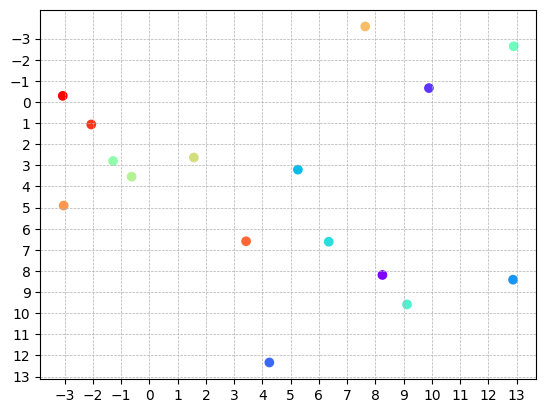

(1, 16, 2)
[[[6.193344   3.9603195 ]
  [8.472157   4.5158453 ]
  [6.1283913  6.0949554 ]
  [8.074226   5.2786136 ]
  [7.8395185  4.5178714 ]
  [8.20294    5.8705025 ]
  [9.106795   7.2063117 ]
  [9.917855   3.7491186 ]
  [1.3873246  2.774637  ]
  [2.0318623  3.3808298 ]
  [2.1658483  2.9126768 ]
  [3.3452754  1.0323739 ]
  [0.94492173 3.0565817 ]
  [0.7458186  1.9564633 ]
  [1.4359627  1.7367651 ]
  [0.7812822  1.1875124 ]]]


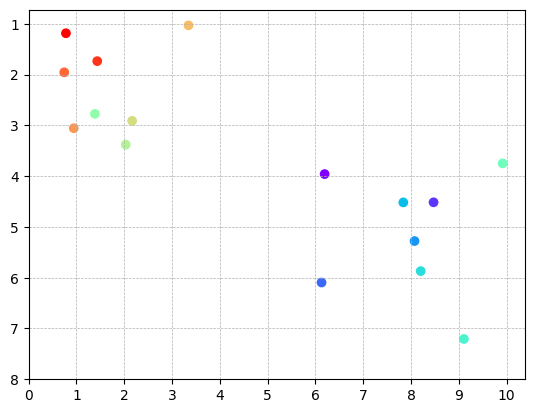

In [117]:
# show a random one
from utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />